In [1]:
from utils import *
import seaborn as sns

sns.set(rc={"figure.figsize": (20, 10)})

In [2]:
nlp = spacy.load("en_core_web_md")

# 1. Amostrando dados para análise

In [3]:
positives_df = pd.read_csv("../data/extreme_positive.csv").drop_duplicates("review_id")
negatives_df = pd.read_csv("../data/extreme_negative.csv").drop_duplicates("review_id")

In [4]:
positives_df["review_body"] = apply_text_processing_pipeline(positives_df["review_body"])
negatives_df["review_body"] = apply_text_processing_pipeline(negatives_df["review_body"])

In [5]:
# Amostrando para caber na memória :(
raw_text_p = "\n".join(positives_df["review_body"].sample(frac=.5).to_list())
raw_text_n = "\n".join(negatives_df["review_body"].to_list())

# 2. Buscando quais palavras tem maior similaridade com "refrigerator" 

Word Embeddings são formas de representação de textual que transformas palavras em "pontos" em um espaço multi-dimensional. Desta forma é possível, dentre outras análises, avaliar a semelhança de palavras utilizando métricas de distância como distância de cossenos e euclidiana. Palavras que aparecem em contextos semelhantes tendem a ficar próximas no espaço de análise. Tendo essas ideias em mente, extraíu-se dos corpos as palavras com maior similaridade a "refrigerator" (produto em estudo) utilizando o spaCy. O pacote utiliza embeddings do tipo GloVe de 300 de dimensão, disponibilizados pelo grupo de NLP de Stanford.

In [6]:
all_text = nlp(raw_text_p + raw_text_n)

In [7]:
threshold = 0.80
reference = nlp("refrigerator")

In [8]:
similar = set()
for tok in all_text:
    # a similaridade é avaliada utilizando o cosseno entre os "vetores de palavras"
    if tok.similarity(reference) > threshold:
        similar.add(tok.text)

In [9]:
similar

{'FREEZER',
 'FRIDGE',
 'FRIG',
 'Freezer',
 'Freezers',
 'Fridge',
 'Fridges',
 'Frig',
 'Icemaker',
 'REFRIGERATOR',
 'REFRIGERATORS',
 'Refrigerator',
 'Refrigerators',
 'crispers',
 'defrost',
 'defrosting',
 'freezer',
 'freezers',
 'fridge',
 'fridges',
 'frig',
 'frige',
 'icebox',
 'icemaker',
 'refridgerator',
 'refrig',
 'refrigerated',
 'refrigerator',
 'refrigerators'}

# 3. Extraindo relações de interesse

## 3.1 Transformando o texto em um documento do spaCy

In [10]:
pos_doc = nlp(raw_text_p)
neg_doc = nlp(raw_text_n)

## 3.2 Buscando por afirmações a respeito de um conjunto pre-definido de sujeitos

Para esta análise, buscaremos nos conjuntos de reviews positivas e negativas por frases que apresentem afirmações (ou declarações) a respeito do produto. Para esta tarefa, utilizaremos o pacote textacy novamente. O pacote utiliza as informações de POS (Part-of-Speech) e analisa as arvores sintáticas disponibilizadas pelo pacote spaCy para extrair declarações a respeito de um sujeito. Como possíveis sujeitos, utilizou-se as palavras mais semelhantes a palavra "refrigerator", extraídas na seção anterior.

A implementação da extração de fatos é baseada no trabalho: <a href="https://www.researchgate.net/publication/221418786_Portable_Extraction_of_Partially_Structured_Facts_from_the_Web">Portable Extraction of Partially Structured Facts from the Web</a>.

In [11]:
possible_subjects = ['it', 'refrigerator', 'fridge', 'freezer']

In [12]:
pos_infos = get_statements(pos_doc, possible_subjects)
neg_infos = get_statements(neg_doc, possible_subjects)

## 3.3 Amostrando resultados

In [13]:
from random import shuffle

In [14]:
shuffle(pos_infos), shuffle(neg_infos)

(None, None)

In [15]:
# Comentários positivos
pos_infos[:20]

[(it, to be, the same as out old two door fridge),
 (It, 's, a nice size),
 (refrigerator, was, 20 years old),
 (Freezer,
  is,
  nice size and frig is a bit smaller than my last but still acceptable.),
 (fridge, has been, quite amazing from the start),
 (fridge, is, at 40 degrees f. Great product),
 (It, was, a great addition to our kitchen),
 (it, is, one if not the best fridge we have ever owned in 38 years),
 (it, is, about the same dimensions as our old fridge),
 (it, is, a loud unit),
 (freezer, is, huge and has drawers for organization),
 (It, was, a large frig and the doorway was tight),
 (freezer,
  could be,
  a little bit bigger, but we have a separate fridge in the garage),
 (Freezer,
  is,
  good too and doesn't have the rounded corners like some of these other freezers do that limit space),
 (it, 's, a GE),
 (It, 's, a perfect fit),
 (fridge, was, .),
 (it, was, still cloudy),
 (fridge,
  was,
  big but had way less interior space than this product that takes up the same 

In [16]:
# Comentários negativos 
neg_infos[:20]

[(refrigerator, is, just slightly cool.),
 (fridge, is, bigger than the space inside),
 (it, would be, at least another week before we would see a technician),
 (it, 's, so noisy that I hear the compressor noise upstairs),
 (it, 'll be, $250 for labor),
 (it, being, a Christmas gift),
 (refrigerator, is, ok exceptA¢AA),
 (it, is, a piece of junk),
 (it, has been, a constant battle for it to function correctly),
 (it, will be, a week that we do not have a fridge),
 (it, 's, a product-wide issue with a couple of simple internet searches),
 (it,
  is,
  almost October and we have been without ice since May since no one can fix it),
 (it, 's, an issue with the compressor),
 (It, is, now over one week and still no service),
 (refrigerator, is, right at three years and about six months old),
 (it,
  's,
  not easy to put an ice maker within the normal refrigeration section of the unit),
 (it, is, so difficult),
 (fridge, was, loud from day 1),
 (It, 's, only good for storing sodas and as a

## 3.4 Serializando todas as informações extraídas

In [17]:
serialize_statements(pos_infos, "../extracted_infos/positive_aspects.json")
serialize_statements(neg_infos, "../extracted_infos/negative_aspects.json")

# 4 Criando núvens de palavras com as afirmações a respeitos dos sujeitos

Gerou-se núvens de palavras de forma similar ao notebook anterior, porém utilizando apelas os as afirmações feitas a respeito dos sujeitos escolhidos.

## 4.1 Carregando palavras frequentes a ignorar

In [18]:
import json
with open("../data/ignore_words.json", "r") as f:
    ignore = json.load(f)

## 4.1 Reviews positivas

In [26]:
statements = [info[2].text for info in pos_infos]
statements[-20:]

['perfect for our family of 4',
 'spacey enough',
 'a very snug fit and removed paint as it slid in',
 'perfect for are galley kitchen',
 'too loud',
 'about 5 inches wide',
 'super quiet!\n',
 'very cold and I love the space',
 'very spacious and cools very well',
 'nice and bright also with LED lights',
 'not noisy',
 'beautiful inside and out',
 'great size for my kitchen and for me',
 'unbelievable had the same size',
 'great to have a fridge that works and this model is spaced well',
 'the first time I have had it and am very happy',
 'very bright',
 'very quiet',
 'well worth the price.\n',
 'the perfect size for my space \n']

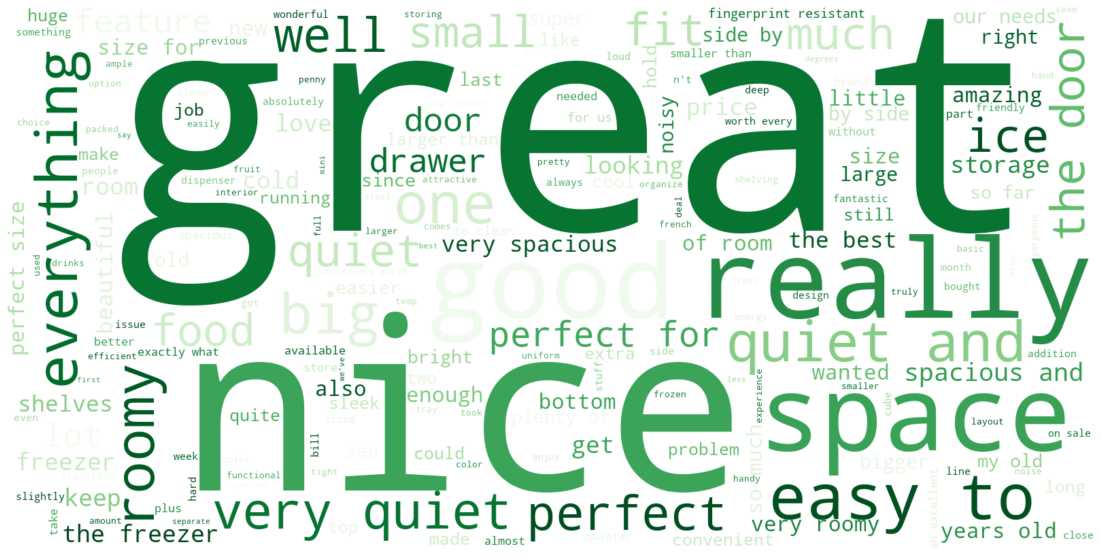

In [27]:
build_wordcloud("\n".join(statements), ignore, color_map="Greens")

## 4.2 Reviews negativas

In [21]:
statements = [info[2].text for info in neg_infos]
statements[-20:]

["like there's a woodpecker hitting metal inside",
 'so problematic',
 'final noisy speed',
 'not fingerprint resistant',
 'a piece expensive junk.\n',
 'a buzzing of the compressor',
 'loud and also it was installed with an uneven door so it squeaks loud every time you open the door',
 'one of the few fridges I could find that would fit in my fridge slot in the kitchen',
 'a few days over a year',
 'terribly noisy',
 'AN EXPENSIVE FRIG AND SAMSUNG',
 'really hard to do without a major appliance, especially one that keeps all your food from spoiling',
 'a maintenance problem',
 'big and deep',
 'a design flaw',
 'a really bad investment',
 'a shame because it looks great and fits the kitchen well',
 'an absolute joke.\n',
 'a much better design and of higher quality construction than the Kitchen Aid',
 'past the 48 hours that Home Depot gives to complain they would do NOTHING']

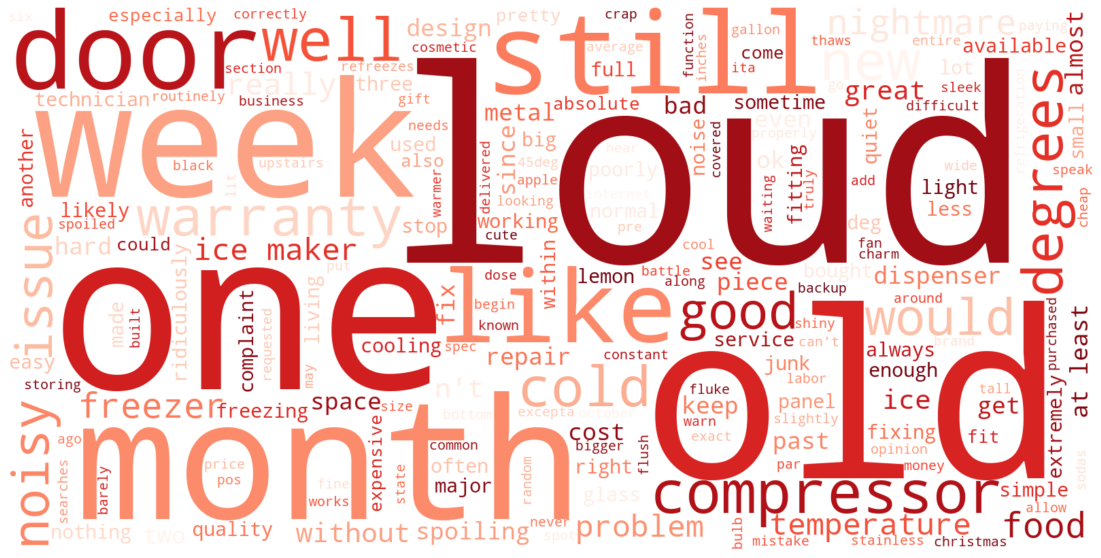

In [23]:
build_wordcloud("\n".join(statements), ignore, color_map="Reds")